In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm
from manada.Sources.sersic import SingleSersicSource
from manada.MainDeflector.simple_deflectors import PEMD
import manada
from manada.Sampling.sampler import Sampler
from manada.Sources.source_base import SourceBase
from lenstronomy.SimulationAPI.data_api import DataAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import matplotlib.pyplot as plt
import os, subprocess, sys
from matplotlib import colors
from astropy.visualization import simple_norm

from fastell4py import _fastell

root_path = manada.__path__[0][:-7]

# Understanding the Manada Pipeline

__Author:__ Sebastian Wagner-Carena, Sydney Erickson

__Goals:__ 

1. Understand each of the two main components (source models, lens models) that goes into the manada image generation pipeline.
2. Work through an example class that inherits from the manada SourceBase class to understand how to make your own classes for use with manada.
3. Understand how to put everything together to create a training set using manada's generate.main() function.

### Table of Contents

1. [Generating a Lens Image](#lens_img_gen) 
2. [Visualizing Parameter Effects](#visualize_params)
3. [Creating a Custom SourceBase Extension](#source)
4. [Generating a Training Set](#train_gen)

## Generating a Lens Image Using Manada <a class="anchor" id="lens_img_gen"></a>

__Goal: Walk through a simplified version of the image generation pipeline to help build understanding of what manada is doing under the hood. Together with the following section, this should enable you to create new source, subhalo, or line-of-sight classes for use with manada.__

At a high level, `manada` enhances the lensing calculations being done by `lenstronomy` by making it convenient to generate large, simulated, machine-learning datasets. To do this, `manada` allows user to translate simple, user-specified distributions for lensing systems into large image datasets without having to interact directly with lenstronomy<sup>1</sup>. For example, say that a researcher wants to generate a dataset of images from a simple two-component lensing distribution: a main deflector whose mass is described by a power-law elliptical mass distribution (PEMD) and a source that can be described by a Sersic profile. To do this they would need to specify a configuration dictionary with the main_deflector models (in this case just the PEMD), the source class (in this case a SingleSersicSource) and the parameters for both:
```
config_dict = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{
            'z_lens': 0.5,
            'gamma': 2.0,
            'theta_E': 1.1,
            'e1': 0.05,
            'e2': -0.1,
            'center_x': 0.06,
            'center_y': 0.08,
        }
    },
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'amp':1.0,
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':0.1,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    }
}
```
Throwing this plus a few numerical options<sup>2</sup> into a Config file would be enough to generate a training set with `generate.py`. The training set would be a bit boring since the lensing configuration is fixed, but that can quickly be fixed by specifying a callable rather than a static number for any parameter. For example the researcher could set:
```
'e1': norm(loc=0.0,scale=0.1).rvs
```
and the first component of the ellipticity would be drawn from a normal distribution. All of the work of using lenstronomy to translate from this configuration to a final dataset is contained within `generate.py` and the various modules it calls. While an effort has been made to ensure that all of the `manda` code is well commented, __what follows is a simplified version of that image generation pipeline__.

<sup>1</sup> `manada` also enables users to specify distributions for noise and instrumental parameters that can then be used to generate simulated observartions. However this notebook will mostly ignore that functionality. 

<sup>2</sup> We will describe these in detail when we go over generating a training set.

--------------------

Let's start by recreating our config_dict object from above. We'll also add some additional information for our cosmology (which we'll fix to planck 2018 results), the psf (which we will set to NONE), and the detector (which we'll give a resolution of 0.08 arcseconds and a hubble-like sensitivity and exposure time).

In [12]:
config_dict = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{'z_lens': 0.5,'gamma': 2.0,'theta_E': 1.1,'e1': 0.05,'e2': -0.1,'center_x': 0.06,'center_y': 0.08}
    },
    'source':{
        'class': SingleSersicSource,
        'parameters':{'amp':1.0,'R_sersic':1.0,'n_sersic':3,'e1':0.1,'e2':0.3,'center_x':0.0,'center_y':0.0,
                      'z_source':1.0}
    },
    'cosmology':{
        'parameters':{'cosmology_name': 'planck18'}
    },
    'psf':{
        'parameters':{'psf_type':'NONE'}
    },
    'detector':{
        'parameters':{'pixel_scale':0.08,'magnitude_zero_point':25,'exposure_time':5400,'read_noise':3.0,
                      'ccd_gain':1.58,'sky_brightness':21.83}
    },
}

`manada` comes with a Sampler class that can be used to draw realizations of the parameterizations specified by a dictionary.
This is overkill for this example since all of the parameter values are fixed, but we'll soon see how the sampler can be
useful when distributions are provided in the config_dict.

In [13]:
sampler = Sampler(config_dict)
sample = sampler.sample()

The most important function of all the line-of-sight, subshalo, main deflector, and source classes in manada is to draw
the lenstronomy parameters required to render the lensing image. Let's quickly interact with that functionality:

In [14]:
# Initialize our main deflector class with the sampled parameter values
md_class = config_dict['main_deflector']['class'](main_deflector_parameters=sample['main_deflector_parameters'],
                                                  cosmology_parameters=sample['cosmology_parameters'])
# Draw the lenstronomy parameters from the class. The class returns a list of lens model names (related to the 
# lens model in lenstronomy), a list of the kwargs for each lens model, and a list of the redshift of each
# lens model.
lens_model_list, lens_kwargs_list, lens_z_list = md_class.draw_main_deflector()

# Repeat the same two steps for the source class. The source class draw_source function returns a list of the
# source model names (again related to lenstronomy) and a list of the kwargs for each source model.
source_class = config_dict['source']['class'](source_parameters=sample['source_parameters'],
                                                  cosmology_parameters=sample['cosmology_parameters'])
source_model_list, source_kwargs_list = source_class.draw_source()
z_source = sample['source_parameters']['z_source']

print('The lensing mass distributions are:') 
print(lens_model_list)
print('The source light distributions are:')
print(source_model_list)
print(source_kwargs_list)

The lensing mass distributions are:
['PEMD']
The source light distributions are:
['SERSIC_ELLIPSE']
[{'R_sersic': 1.0, 'amp': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.1, 'e2': 0.3, 'n_sersic': 3}]


Now we can convert those parameters to lenstronomy inputs. We will roughly outline each step along the way, but suggest reading the lenstronomy documentation for a fuller explanantion.

In [15]:
# We need to tell lenstronomy how big we want the image to be!
numpix = 64

# We need to set the numerical kwargs for use in lenstronomy. The only one we'll specify here is the supersampling
# factor. This defines how many rays are shot per pixel. A value of 1 is 1 per pixel, and 2 is 2x2 = 4 per pixel.
kwargs_numerics = {'supersampling_factor':2}

# Generate our lens and light model using the lists output by our manada objects.
lens_model = LensModel(lens_model_list)
light_model = LightModel(source_model_list)

# We'll also need a psf model and a data_api object to pass into the lenstronomy. Thankfully we've already
# sampled all the kwargs for these from our config_dict.
psf_model = PSF(**sample['psf_parameters']) 
data_api = DataAPI(numpix=numpix,**sample['detector_parameters'])

# Now we can make the image model and our image
image_model = ImageModel(data_api.data_class, psf_model, lens_model, light_model, None, None, 
                         kwargs_numerics=kwargs_numerics)
# 2d array of surface brightness pixels of the simulation
image = image_model.image(lens_kwargs_list, source_kwargs_list, None, None)

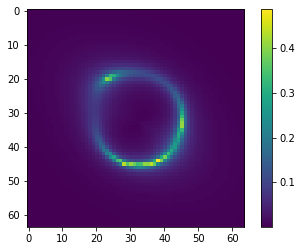

In [7]:
# Now we can visualize our lens!
plt.imshow(image)
plt.colorbar()
plt.show()

We can add one more wrinkle to the simplified pipeline above to bring it closer to what is done in `manada`: let's specify a distribution for some of our source and lens parameters!

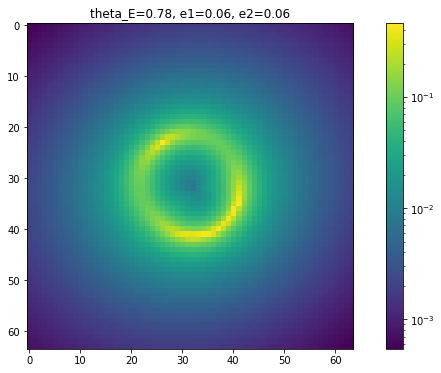

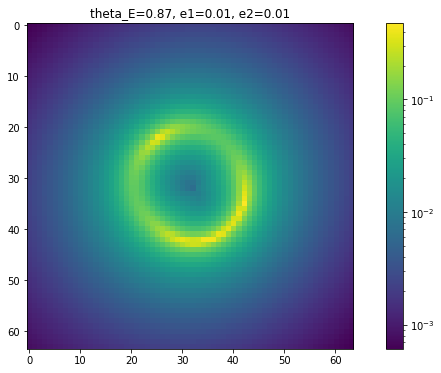

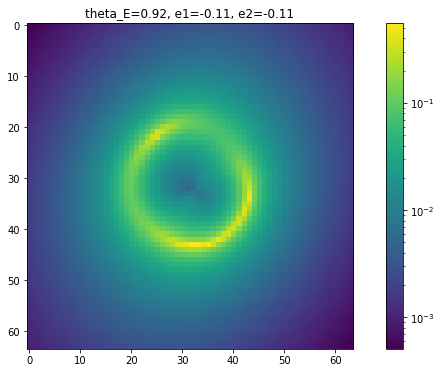

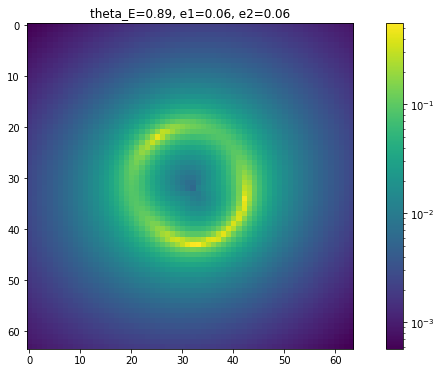

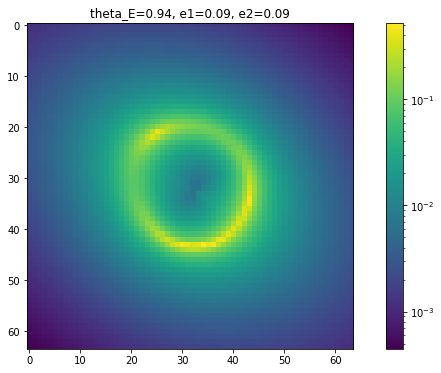

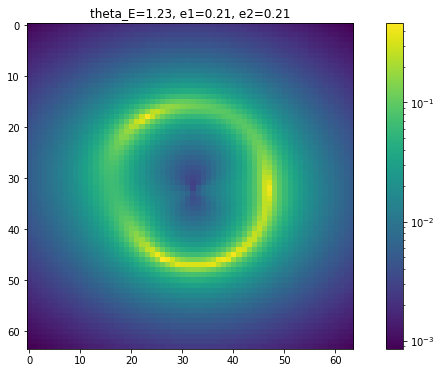

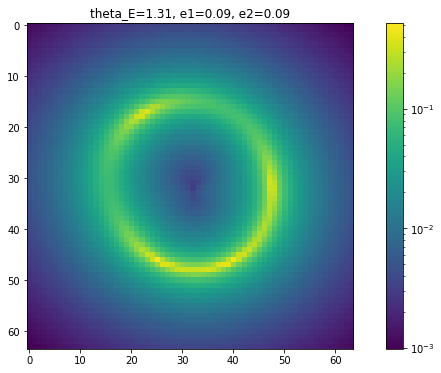

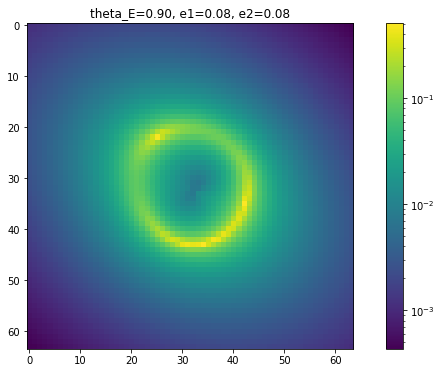

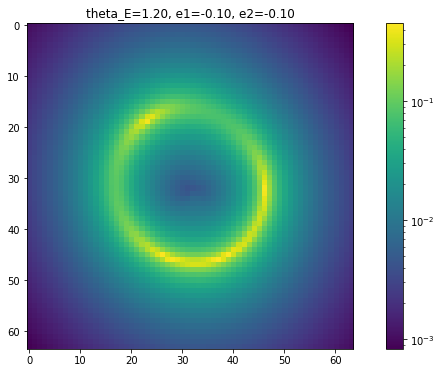

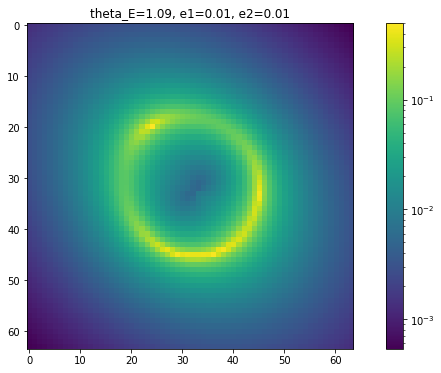

In [16]:
# Modify the config dict. Start by varing the Einstein radius and ensuring it never goes below 0.
config_dict['main_deflector']['parameters']['theta_E'] = truncnorm(-1.1/0.2,np.inf,loc=1.1,scale=0.2).rvs

# Repeat the same for the ellipticity of the source
config_dict['source']['parameters']['e1'] = norm(loc=0.0,scale=0.1).rvs
config_dict['source']['parameters']['e2'] = norm(loc=0.0,scale=0.1).rvs

# Create our new sampler with this config_dict
sampler = Sampler(config_dict)

# Now let's repeat the code above, drawing multiple samples!
for i in range(10):
    sample = sampler.sample()
    
    # We don't need to reinitialize our classes, just update the parameters. This is useful if our class is doing some
    # expensive calculation we want to cache for future calls.
    md_class.update_parameters(main_deflector_parameters=sample['main_deflector_parameters'])
    lens_model_list, lens_kwargs_list, lens_z_list = md_class.draw_main_deflector()
    source_class.update_parameters(source_parameters=sample['source_parameters'])
    source_model_list, source_kwargs_list = source_class.draw_source()
    z_source = sample['source_parameters']['z_source']
    
    # Go through the lenstronomy steps again
    lens_model = LensModel(lens_model_list)
    light_model = LightModel(source_model_list)
    psf_model = PSF(**sample['psf_parameters']) 
    data_api = DataAPI(numpix=numpix,**sample['detector_parameters'])
    image_model = ImageModel(data_api.data_class, psf_model, lens_model, light_model, None, None, 
                             kwargs_numerics=kwargs_numerics)
    # 2d array of surface brightness pixels of the simulation
    image = image_model.image(lens_kwargs_list, source_kwargs_list, None, None)

    #Plot Images
    #suggestions: normalize to log scale, label using theta_E, e1, e2, subplot
    plt.imshow(image, norm=colors.LogNorm())
    plt.colorbar()
    # e1 e2 of Sersic, not e1, e2 of lens
    title = "theta_E=%.2f"%lens_kwargs_list[0]['theta_E'] + ", e1=%.2f"%source_kwargs_list[0]['e1'] + ", e2=%.2f"%source_kwargs_list[0]['e1']
    plt.title(title)
    plt.show()
    

## Visualizing Lens Parameter Effects <a class="anchor" id="visualize_params"></a>

__Goal: Vary parameters to understand how different values affect final images.__

It is helpful to build an intuition for how each parameter should affect the lensed image. In the TODO section below, specify which parameter you would like to vary & what values you would like to test. All other parameters will be held constant. Then, 5 output images will be plotted in parameter-sorted order. 

For reference, here are the distributions used: 

    'main_deflector':{
			'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
			'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
			'e1': norm(loc=0.0,scale=0.1).rvs,
			'e2': norm(loc=0.0,scale=0.1).rvs,
			'center_x': norm(loc=0.0,scale=0.1).rvs,
			'center_y': norm(loc=0.0,scale=0.16).rvs,
		},

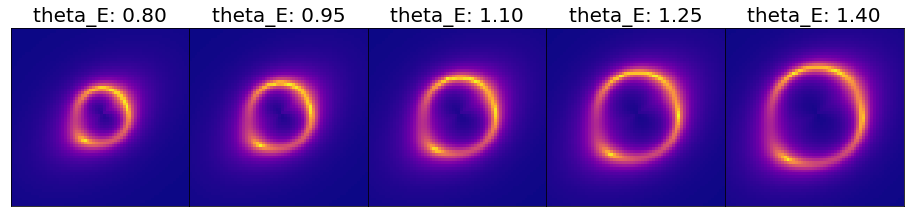

In [19]:
#TODO: Decide which parameter to vary and provide 5 values
param = 'theta_E'
param_vals = [0.8, 0.95, 1.1, 1.25, 1.4]

#Undo changes from prior code block
config_dict['main_deflector']['parameters']['theta_E'] = 1.1
config_dict['source']['parameters']['e1'] = 0.1
config_dict['source']['parameters']['e2'] = 0.3

images = []

# Run same code again (copied from above portion)
for i in range(5):
	sample = sampler.sample()
	sample['main_deflector_parameters'][param] = param_vals[i]
    
    # We don't need to reinitialize our classes, just update the parameters. This is useful if our class is doing some
    # expensive calculation we want to cache for future calls.
	md_class.update_parameters(main_deflector_parameters=sample['main_deflector_parameters'])
	lens_model_list, lens_kwargs_list, lens_z_list = md_class.draw_main_deflector()
	source_class.update_parameters(source_parameters=sample['source_parameters'])
	source_model_list, source_kwargs_list = source_class.draw_source()
	z_source = sample['source_parameters']['z_source']
    
	# Go through the lenstronomy steps again
	lens_model = LensModel(lens_model_list)
	light_model = LightModel(source_model_list)
	psf_model = PSF(**sample['psf_parameters']) 
	data_api = DataAPI(numpix=numpix,**sample['detector_parameters'])
	image_model = ImageModel(data_api.data_class, psf_model, lens_model, light_model, None, None, 
                             kwargs_numerics=kwargs_numerics)
    # 2d array of surface brightness pixels of the simulation
	images.append(image_model.image(lens_kwargs_list, source_kwargs_list, None, None) )


#sort images from lowest param value to highest, then plot 
order = np.argsort(param_vals) 

norm=simple_norm(images[0], stretch='asinh', min_cut=1e-4)
f, ax = plt.subplots(1,5,figsize=(16,5),gridspec_kw={'hspace': 0.1})
f.subplots_adjust(wspace=0.0)

for i in range(0,5) :
	ax[i].get_xaxis().set_visible(False)
	ax[i].get_yaxis().set_visible(False)
	ax[i].matshow(images[order[i]], origin='lower', norm=norm, cmap='plasma')
	title = param + ": %.2f"%param_vals[order[i]]
	ax[i].set_title(title, fontsize=20)

plt.show()

## Creating a Custom SourceBase Extension <a class="anchor" id="source"></a>

__Goal: Build a source class from sratch and understand how to create new source, subhalo, or line-of-sight classes for use with manada.__

`manada` already has a set of pre-built classes for the main deflector, the source, the line-of-sight structure, and the subhalos. However, it is likely that in using the package a user will want to modify the assumptions being made by one or more of these classes. Let's walk through how to build a new source class and use it to generate a few strong lensing images.

Any source class we build for `manada` needs to inherit from SourceBase to ensure that it interacts correctly with the dataset generation pipeline. You'll notice that there is one function in SourceBase that is not implemented:

```
class SourceBase:
    """
    Base class for producing lenstronomy LightModel arguments

    Args:
        cosmology_parameters (str,dict, or
            colossus.cosmology.cosmology.Cosmology): Either a name
            of colossus cosmology, a dict with 'cosmology name': name of
            colossus cosmology, an instance of colussus cosmology, or a
            dict with H0 and Om0 ( other parameters will be set to defaults).
        source_parameters: dictionary with source-specific parameters
    """

    required_parameters = tuple()

    ......

    def draw_source(self):
        """Return lenstronomy LightModel names and kwargs

        Returns:
            (list,list) A list containing the model name(s), and
                a list containing the model kwargs dictionaries.
        """
        raise NotImplementedError
```

After inheriting from SourceBase, this is the only function that _must_ be implemented. We are also free to add any other functions to our class that will help in our implementation of `draw_source`. The only other property that _must_ be set in our new class are the `required_parameters`. When the class is initialized, it will check that the required parameters are all
present within `source_parameters`. This list is also useful for users that want to know what parameters the class will expect.

One easy but interesting extension we can make is a source consisting of two seperate sersic profiles.

--------------------

Let's start by building our new class.

In [ ]:
class DoubleSersicSource(SourceBase):
    """Class to generate single Sersic profile light models

    Args:
        cosmology_parameters (str,dict, or
            colossus.cosmology.cosmology.Cosmology): Either a name
            of colossus cosmology, a dict with 'cosmology name': name of
            colossus cosmology, an instance of colussus cosmology, or a
            dict with H0 and Om0 ( other parameters will be set to defaults).
        source_parameters: dictionary with source-specific parameters.
    """

    # These are the required parameters. In this case we need the seven parameters for our two sersic profiles.
    required_parameters = ['amp_s1','R_sersic_s1','n_sersic_s1','e1_s1','e2_s1','center_x_s1','center_y_s1',
                           'amp_s2','R_sersic_s2','n_sersic_s2','e1_s2','e2_s2','center_x_s2','center_y_s2',
                           'z_source']

    # Our light model list and light kwargs are fairly simple, so we can pull them straight from our
    # source_parameters.
    def draw_source(self):
        """Return lenstronomy LightModel kwargs

        Returns:
            (list,list) A list containing the model names(s), and
                a list containing the model kwargs dictionaries.
        """
        light_model_list = ['SERSIC_ELLIPSE','SERSIC_ELLIPSE']
        light_kwargs_list = []
        # We can extract the kwargs for our two light models using the suffix
        for suffix in ['s1','s2']:
            kwargs_dict = {}
            for param_name in self.__class__.required_parameters:
                if suffix in param_name:
                    kwargs_dict[param_name[:-3]] = self.source_parameters[param_name]
            light_kwargs_list.append(kwargs_dict)
        
        return light_model_list, light_kwargs_list

Now we can use our new class in the same simplistic pipeline we outlined above. All we need to do is modify our `config_dict`.

In [ ]:
# All we need to do is modify the source parameters
config_dict['source'] = {
    'class': DoubleSersicSource,
    'parameters':{'amp_s1':1.0,
                  'R_sersic_s1':1.0,
                  'n_sersic_s1':1.5,
                  'e1_s1':norm(loc=0.0,scale=0.1).rvs,
                  'e2_s1':norm(loc=0.0,scale=0.1).rvs,
                  'center_x_s1':norm(loc=-0.1,scale=0.1).rvs,
                  'center_y_s1':norm(loc=-0.1,scale=0.1).rvs,
                  'amp_s2':1.0,
                  'R_sersic_s2':1.0,
                  'n_sersic_s2':1.5,
                  'e1_s2':norm(loc=0.0,scale=0.1).rvs,
                  'e2_s2':norm(loc=0.0,scale=0.1).rvs,
                  'center_x_s2':norm(loc=0.1,scale=0.1).rvs,
                  'center_y_s2':norm(loc=0.1,scale=0.1).rvs,
                  'z_source':1.0}
    }

# Let's keep the main deflector parameter fixed again.
config_dict['main_deflector']['parameters']['theta_E'] = 1.0

# Create our new sampler with this config_dict
sampler = Sampler(config_dict)

# Initialize our source class once
sample = sampler.sample()
source_class = config_dict['source']['class'](source_parameters=sample['source_parameters'],
                                              cosmology_parameters=sample['cosmology_parameters'])

# Now let's repeat the code above, drawing multiple samples!
for i in range(10):
    sample = sampler.sample()
    
    # We don't need to reinitialize our classes, just update the parameters. This is useful if our class is doing some
    # expensive calculation we want to cache for future calls.
    md_class.update_parameters(main_deflector_parameters=sample['main_deflector_parameters'])
    lens_model_list, lens_kwargs_list, lens_z_list = md_class.draw_main_deflector()
    source_class.update_parameters(source_parameters=sample['source_parameters'])
    source_model_list, source_kwargs_list = source_class.draw_source()
    z_source = sample['source_parameters']['z_source']
    
    # Go through the lenstronomy steps again
    lens_model = LensModel(lens_model_list)
    light_model = LightModel(source_model_list)
    psf_model = PSF(**sample['psf_parameters']) 
    data_api = DataAPI(numpix=numpix,**sample['detector_parameters'])
    image_model = ImageModel(data_api.data_class, psf_model, lens_model, light_model, None, None, 
                             kwargs_numerics=kwargs_numerics)
    image = image_model.image(lens_kwargs_list, source_kwargs_list, None, None)
    
    #plt.imshow(image, norm=colors.LogNorm())
    plt.imshow(image)
    plt.colorbar()
    title = "theta_E=%.2f"%lens_kwargs_list[0]['theta_E'] + ", e1=%.2f"%lens_kwargs_list[0]['e1'] + ", e2=%.2f"%lens_kwargs_list[0]['e1']
    plt.title(title)
    plt.show()
    

And that's it! If you wanted to use the DoubleSersicSource class to make datasets of strong gravitational lenses you now could.

## Generating a Training Set <a class="anchor" id="train_gen"></a>

__Goal: Look at a config module used by `generate.py` and use it to make a small training set.__

While going through the pipeline above is helpful for gaining intuition on how manada works, in most cases we'll want to rapidly iterate on our training set without having to interact closely with the dataset pipeline. For this reason, `manada` employs configuration modules that can be pointed to directly in calls to `generate.py`.

An example configuration module is given in `notebook_data/config_example.py`. Let's reproduce it here:

```
import numpy as np
from scipy.stats import norm, truncnorm
from manada.MainDeflector.simple_deflectors import PEMD
from manada.Sources.sersic import SingleSersicSource

# Define the numerics kwargs.
kwargs_numerics = {'supersampling_factor':2}

# The number of pixels in the CCD.
numpix = 64

# Define some general image kwargs for the dataset
# The radius in arcseconds of a mask to apply at the center of the image
mask_radius = 0.5
# A magnification cut - images where the source is magnified by less than this
# factor will be resampled.
mag_cut = 2.0

config_dict = {
	'main_deflector':{
		'class': PEMD,
		'parameters':{
			'M200': 1e13,
			'z_lens': 0.5,
			'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
			'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
			'e1': norm(loc=0.0,scale=0.1).rvs,
			'e2': norm(loc=0.0,scale=0.1).rvs,
			'center_x': norm(loc=0.0,scale=0.1).rvs,
			'center_y': norm(loc=0.0,scale=0.16).rvs,
		}
	},
	'source':{
		'class': SingleSersicSource,
		'parameters':{
			'z_source':1.5,
			'amp':truncnorm(-1.0/0.2,np.inf,loc=1.0,scale=0.2).rvs,
			'R_sersic':truncnorm(-1.0/0.2,np.inf,loc=1.0,scale=0.2).rvs,
			'n_sersic':truncnorm(-1.2/0.2,np.inf,loc=1.2,scale=0.2).rvs,
			'e1':norm(loc=0.0,scale=0.1).rvs,
			'e2':norm(loc=0.0,scale=0.1).rvs,
			'center_x':0.0,
			'center_y':0.0}
	},
	'cosmology':{
		'parameters':{
			'cosmology_name': 'planck18'
		}
	},
	'psf':{
		'parameters':{
			'psf_type':'GAUSSIAN',
			'fwhm': 0.04
		}
	},
	'detector':{
		'parameters':{
			'pixel_scale':0.04,'ccd_gain':1.58,'read_noise':3.0,
			'magnitude_zero_point':25.127,
			'exposure_time':1380,'sky_brightness':21.83,
			'num_exposures':1,'background_noise':None
		}
	}
}
```

Most of this should look familiar based on what we've outlined in the notebook. The first portion specifies a few global options like the size of the images in pixels, the radius of a central mask, the magnificaiton cut to demand of the output images, and the numerics of the sampling for lenstronomy. The rest is just another example of the `config_dict` objects we've been building throughout this notebook. Unlike in our previous examples, now almost all of the parameters are being drawn from distributions for our main deflector and our source.

Let's go ahead an use this configuration module to generate a training set.

--------------------

Calling the generate function is fairly simple. We can use the help option to see what the arguments are

In [ ]:
# Change our working directory to the location of generate.py and run 'python generate.py --help'
os.chdir(os.path.join(root_path,'manada'))
help_call = subprocess.run(['python','generate.py','--help'],stdout=subprocess.PIPE, text=True)
print(help_call.stdout)

Let's make a dataset with 10 images using generate.py. Since we're making the calls from python instead of the terminal we'll have to use `sys.argv` to pass arguments to `generate.main`. From the terminal all we would have to do is type
```
python generate.py path/to/config path/to/output/folder --n 10
```
Also one word of warning for calling the generation pipeline through python code as we do here: 'generate.py' loads the configuration module 'config_example.py'. By default python does not reload a module once it has already been loaded even if import is called again. Therefore, if you run this notebook, change `config_example.py` without resetting the ipython kernel, and then run this cell again it will not reflect the changes made to `config_example.py`. In general you should only call `generate.py` from the terminal, in which case this issue will not arise.

In [ ]:
# Set the system arguments as the path to our config file, the path to our output folder, and the number of images we 
# want to generate.
config_path = os.path.join(root_path,'notebooks/notebook_data/config_example.py')
output_path = os.path.join(root_path,'notebooks/notebook_data/example_dataset')
sys.argv = ['generate',config_path,output_path,'--n','10']
manada.generate.main()

And you've just made your first 10 image dataset. We can finish up by taking a look at what was produced.

Inside example_dataset we'll find a copy of the configuration module used to generate the data, the strong lensing images, and a csv file with all of the metadata. Let's quickly iterate through it to make sure everything looks good.

In [ ]:
# Load the metadata
metadata = pd.read_csv(os.path.join(output_path,'metadata.csv'), index_col=None)

# Let's go through the images and take a look at each image and its einstein radius.
for nt in range(len(metadata)):
    image = np.load(os.path.join(output_path,'image_%07d.npy'%nt))
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    print('Image %d , Einstein radius %.2f'%(nt,metadata['main_deflector_parameters_theta_E'][nt]))